In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)

In [3]:
# an AND gate has 4 possible outcomes: 0^0=0, 0^1=0, 1^0=0, 1^1=1
# Since the state can only be 0 or 1, I propolate the sample with Logistic Distribution
n = 10_000
mean, scale = 0.5, 0.15
x1 = np.random.logistic(mean, scale, n)
x2 = np.random.logistic(mean, scale, n)
x = np.column_stack((x1, x2))

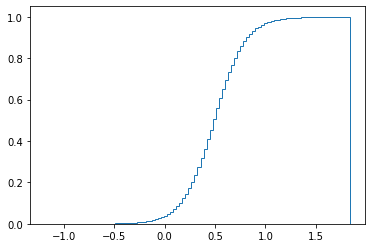

In [4]:
bins=100
plt.figure()
plt.hist(x1, bins, density=True, histtype='step', cumulative=True, label='CDF')
plt.show()

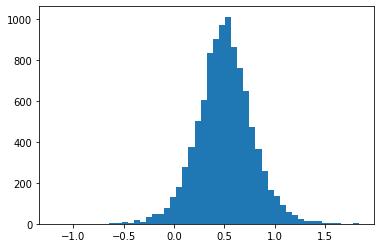

In [5]:
plt.figure()
count, bins, ignored = plt.hist(x1, bins=50)
plt.show()

In [6]:
y = np.array([1 if x_i[0] >= 0.5 and x_i[1] >= 0.5 else 0 for x_i in x])

In [7]:
# around 25% of points are output 1
print(y[y==1].size/n)

0.2603


In [8]:
figsize = np.array(plt.rcParams["figure.figsize"]) * 2

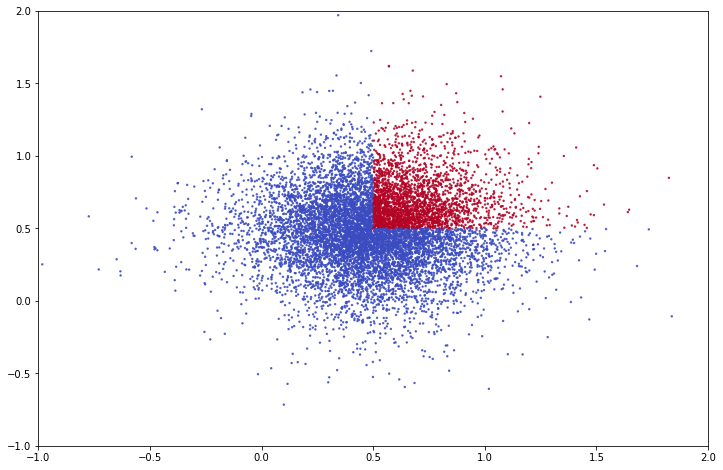

In [9]:
x_min, x_max = -1.0, 2

plt.figure(figsize=figsize.tolist())
plt.scatter(x[:, 0], x[:, 1], marker='.', c=y, alpha=0.8, cmap=plt.cm.coolwarm, s=8, edgecolor='face')
plt.grid(False)
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

In [11]:
# SVM
gamma = 10.0
C = 1000
model = svm.SVC(kernel='rbf', decision_function_shape='ovo', random_state=random_state, gamma=gamma, C=C)
model.fit(x_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=10.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=4096, shrinking=True,
    tol=0.001, verbose=False)

In [12]:
print(f'With gamma={gamma} and C={C}')

y_pred = model.predict(x_train)
score = accuracy_score(y_train, y_pred)
print(f'Accuracy on train set = {score*100:.3f}%')

y_pred = model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set = {score*100:.3f}%')

With gamma=10.0 and C=1000
Accuracy on train set = 99.800%
Accuracy on test set = 99.600%


In [13]:
print(model.predict([[1., 1.]]))
print(model.predict([[1., 0.]]))
print(model.predict([[0., 1.]]))
print(model.predict([[0., 0.]]))

[1]
[0]
[0]
[0]


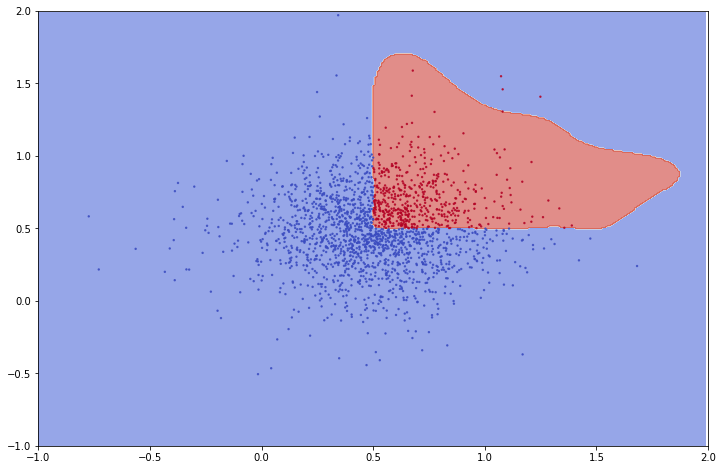

In [14]:
h = .01
# by symmetry x and y axis should be in same range
# x_min, x_max = x_test[:, 0].min() - 1, x_test[:, 0].max() + 1
x_min, x_max = -1.0, 2

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='.', alpha=0.8, cmap=plt.cm.coolwarm, s=8, edgecolor='face')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()

In [15]:
def print_adversarial_examples(model):
    print(f'0.53^1.42={model.predict([[.53, 1.42]])[0]}')
    print(f'0.54^1.42={model.predict([[.54, 1.42]])[0]}')
    print(f'0.54^1.43={model.predict([[.54, 1.43]])[0]}\n')

    print(f'0.53^1.43={model.predict([[.53, 1.43]])[0]}')
    print(f'0.52^1.43={model.predict([[.52, 1.43]])[0]}\n')

    print(f'0.5^0.499={model.predict([[.5, .499]])[0]}')
    print(f'0.501^0.51={model.predict([[.501, .51]])[0]}')

In [16]:
print_adversarial_examples(model)

0.53^1.42=1
0.54^1.42=1
0.54^1.43=1

0.53^1.43=1
0.52^1.43=1

0.5^0.499=0
0.501^0.51=0


In [17]:
model.get_params()

{'C': 1000,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 10.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### SVM with overfit parameter

By increasing gamma, kernel function works better in the center.

In [18]:
gamma = 60.0
C = 1000
model2 = svm.SVC(kernel='rbf', decision_function_shape='ovo', random_state=random_state, gamma=gamma, C=C)
model2.fit(x_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=60.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=4096, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
print(f'With gamma={gamma} and C={C}')
y_pred = model2.predict(x_train)
score = accuracy_score(y_train, y_pred)
print(f'Accuracy on train set = {score*100:.3f}%')

y_pred = model2.predict(x_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy on test set = {score*100:.3f}%')

With gamma=60.0 and C=1000
Accuracy on train set = 99.938%
Accuracy on test set = 99.750%


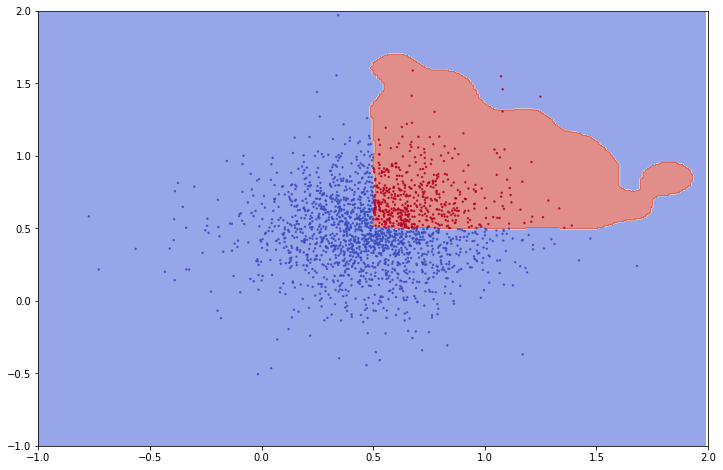

In [20]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))
Z = model2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.6)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker='.', alpha=0.8, cmap=plt.cm.coolwarm, s=8, edgecolor='face')
plt.xlim(x_min, x_max)
plt.ylim(x_min, x_max)
plt.show()

In [21]:
print_adversarial_examples(model2)

0.53^1.42=1
0.54^1.42=1
0.54^1.43=1

0.53^1.43=0
0.52^1.43=0

0.5^0.499=0
0.501^0.51=1


In [22]:
model2.get_params()

{'C': 1000,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovo',
 'degree': 3,
 'gamma': 60.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Conclusion

The adversarial examples do exist in both models, but in different regions.

## Neural Network Model

In [23]:
import tensorflow as tf
from tensorflow import keras

In [42]:
model_nn = keras.Sequential([
    keras.layers.Dense(2, 
                       input_shape=(2,), 
                       activation='relu', 
                       kernel_initializer=tf.initializers.GlorotNormal
                      ),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [43]:
model_nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

In [44]:
model_nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [46]:
epochs = 50
batch_size = 32
model_nn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model_nn.evaluate(x_test, y_test, verbose=2)

Train on 8000 samples
Epoch 1/50
8000/8000 [==============================] - 0s 34us/sample - loss: 0.3081 - accuracy: 0.8480
Epoch 2/50
8000/8000 [==============================] - 0s 49us/sample - loss: 0.3084 - accuracy: 0.8520
Epoch 3/50
8000/8000 [==============================] - 0s 52us/sample - loss: 0.3075 - accuracy: 0.8486
Epoch 4/50
8000/8000 [==============================] - 0s 50us/sample - loss: 0.3077 - accuracy: 0.8495
Epoch 5/50
8000/8000 [==============================] - 0s 51us/sample - loss: 0.3075 - accuracy: 0.8489
Epoch 6/50
8000/8000 [==============================] - 0s 28us/sample - loss: 0.3071 - accuracy: 0.8480
Epoch 7/50
8000/8000 [==============================] - 0s 41us/sample - loss: 0.3080 - accuracy: 0.8478
Epoch 8/50
8000/8000 [==============================] - 0s 50us/sample - loss: 0.3074 - accuracy: 0.8509
Epoch 9/50
8000/8000 [==============================] - 0s 50us/sample - loss: 0.3076 - accuracy: 0.8497
Epoch 10/50
8000/8000 [==========

[0.3049194633960724, 0.8465]

In [47]:
model_nn.weights

[<tf.Variable 'dense_4/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[1.522606 , 1.6276698],
        [1.5873944, 1.6936586]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(2,) dtype=float32, numpy=array([-0.88840276, -0.9635287 ], dtype=float32)>,
 <tf.Variable 'dense_5/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[2.5343847],
        [2.2108438]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([-5.789421], dtype=float32)>]

In [48]:
print(model_nn.predict([[1.0, 1.0]]))
print(model_nn.predict([[0.0, 1.0]]))
print(model_nn.predict([[1.0, 0.0]]))
print(model_nn.predict([[0.0, 0.0]]))

[[0.99365485]]
[[0.08289067]]
[[0.06216431]]
[[0.00305042]]


In [50]:
print(f'0.53^1.42={model_nn.predict([[.53, 1.42]])[0][0]}')
print(f'0.54^1.42={model_nn.predict([[.54, 1.42]])[0][0]}')
print(f'0.54^1.43={model_nn.predict([[.54, 1.43]])[0][0]}\n')

print(f'0.53^1.43={model_nn.predict([[.53, 1.43]])[0][0]}')
print(f'0.52^1.43={model_nn.predict([[.52, 1.43]])[0][0]}\n')

print(f'0.5^0.499={model_nn.predict([[.5, .499]])[0][0]}')
print(f'0.501^0.51={model_nn.predict([[.501, .51]])[0][0]}')

0.53^1.42=0.9919264316558838
0.54^1.42=0.9925022125244141
0.54^1.43=0.9930586814880371

0.53^1.43=0.9925253391265869
0.52^1.43=0.9919512271881104

0.5^0.499=0.07132470607757568
0.501^0.51=0.07772853970527649
